# Deep Learning
## Individual Assignment (ISB AMPBA B23)
### Part 4: Image Classification using Transfer Learning

By
| PGID     | Name               |
|----------|-------------------|
| 12420055 | Abhinav Paul      |

#### Package installation and Import statments

In [15]:
# !pip install torch torchvision numpy matplotlib scikit-learn pandas warnings

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings("ignore")


In [17]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#### 1. Data load

In [18]:
# My local file path were I have dowloaded the data from https://www.kaggle.com/datasets/kmkarakaya/logos-bk-kfc-mcdonald-starbucks-subway-none
data_dir = '/Users/abhinavpaul/Desktop/Goals/Exec Edu/1. ISB AMPBA/Course Material/Term 3/2. DL/Assignment/Data/Logos_BK_KFC_McDonaldStarbucksSubwayNone/logos_v3_mini/logos3/'


#### 2. Pre-Processing and resizing the images for Test / Train

In [19]:
# preprocessing Resize images, convert to tensor, and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=data_dir+'/train/', transform=transform)
val_dataset = datasets.ImageFolder(root=data_dir+'/test/', transform=transform)

In [20]:
train_class_names = train_dataset.classes
print("Classes:", train_class_names)

Classes: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']


In [21]:
val_class_names = val_dataset.classes
print("Classes:", val_class_names)

Classes: ['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']


In [22]:
if train_class_names == val_class_names: 
    print("Class names match")
    class_names = train_class_names
    print(class_names)
else:
    print("Class names do not match")

Class names match
['Burger King', 'KFC', 'McDonalds', 'Other', 'Starbucks', 'Subway']


In [23]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Set shuffle=False for validation data loader since we don't want to shuffle the data every epoch and it might
# cause the model to overfit to the validation data.
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

#### 3. Load Pre-trained ResNet50 model

In [24]:
resnet = models.resnet50(pretrained=True)

#### 4. Replace last fully connected layer

In [25]:
# Extract the number of input features from the pre-trained ResNet model
num_features = resnet.fc.in_features

# Replace the fully connected layer (fc) of the ResNet model with a new one
# that outputs predictions for all classes (len(class_names))
resnet.fc = nn.Linear(num_features, len(class_names))

# Move the ResNet model to the specified device (e.g., GPU if available)
resnet = resnet.to(device)

#### 5. Freeze the weights of the pre-trained layers and train only the last layer.

In [26]:
# Freeze all layers except the last one
for param in resnet.parameters():
    param.requires_grad = False  # Freeze parameters

# Only train the last layer
for param in resnet.fc.parameters():
    param.requires_grad = True  # Train the last layer parameters

In [27]:
# Define the loss function
criterion = nn.CrossEntropyLoss()  # Cross entropy loss for multi-class classification

# Define the optimizer
optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)  # Adam optimizer with learning rate 0.001

In [ ]:
epochs = 5  # Number of training epochs kept small as the code was running for more than 3 hurs in highr number causing issue with my local machine CPU utilization
train_losses = []
val_losses = []

# Training loop
for epoch in range(epochs):
    # Set model to training mode
    resnet.train()
    running_loss = 0.0

    # Iterate over training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Reset gradients
        optimizer.zero_grad()
        
        # Forward pass, compute loss
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        # Backward pass, compute gradients
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item()
        
    # Calculate average train loss
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation loss
    resnet.eval()
    val_loss = 0.0
    
    # Disable gradient calculation to save memory
    with torch.no_grad():
        # Iterate over validation data
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    # Calculate average validation loss
    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")


Epoch 1/5, Train Loss: 0.9211, Val Loss: 1.1503
Epoch 2/5, Train Loss: 0.4102, Val Loss: 1.0427
Epoch 3/5, Train Loss: 0.2915, Val Loss: 0.9156
Epoch 4/5, Train Loss: 0.2114, Val Loss: 1.0573
Epoch 5/5, Train Loss: 0.1796, Val Loss: 1.0566


#### 6. Evaluation of the model using Validation set

In [29]:
resnet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

frozen_acc = accuracy_score(y_true, y_pred) * 100
frozen_prec, frozen_rec, frozen_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")


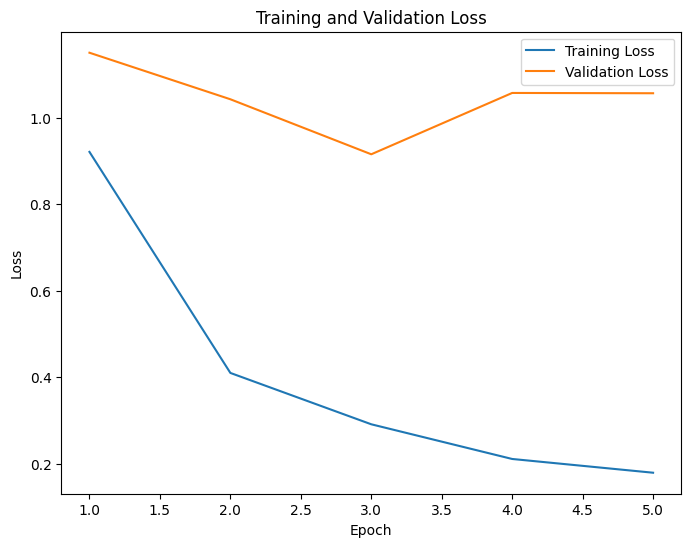

In [30]:
plt.figure(figsize=(8,6))
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


Confusion Matrix and Classification Report (only last fully connected layer trained)

<Figure size 800x600 with 0 Axes>

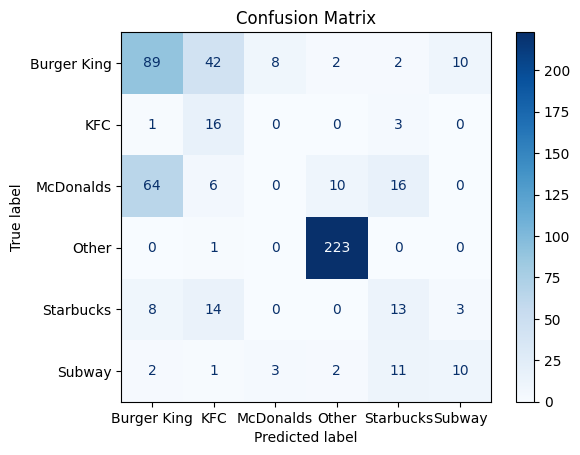

Classification Report:
              precision    recall  f1-score   support

 Burger King       0.54      0.58      0.56       153
         KFC       0.20      0.80      0.32        20
   McDonalds       0.00      0.00      0.00        96
       Other       0.94      1.00      0.97       224
   Starbucks       0.29      0.34      0.31        38
      Subway       0.43      0.34      0.38        29

    accuracy                           0.63       560
   macro avg       0.40      0.51      0.42       560
weighted avg       0.57      0.63      0.59       560



In [31]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#### 7. Fine tuning the modelby Unfreezing the last few layers and training them also

In [ ]:
# Fine-tune only the last layer and the fully connected layer
# of the pre-trained ResNet-18 model
for name, param in resnet.named_parameters():
    if "layer4" in name or "fc" in name:  # last block + fc layer
        param.requires_grad = True
    else:
        param.requires_grad = False

# Initialize the optimizer with the parameters that require gradient
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=1e-5)

# Number of epochs to fine-tune
fine_tune_epochs = 5 # Number of training epochs kept small as the code was running for more than 3 hurs in highr number causing issue with my local machine CPU utilization

# Fine-tune the model
for epoch in range(fine_tune_epochs):
    resnet.train()  # Set model to training mode
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()  # Clear gradients
        outputs = resnet(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()
        
    print(f"Fine-Tune Epoch {epoch+1}/{fine_tune_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Fine-Tune Epoch 1/5, Loss: 0.1115
Fine-Tune Epoch 2/5, Loss: 0.0378
Fine-Tune Epoch 3/5, Loss: 0.0232
Fine-Tune Epoch 4/5, Loss: 0.0134
Fine-Tune Epoch 5/5, Loss: 0.0103


#### 8. Evaluate the finetuned model

In [33]:
resnet.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

finetuned_acc = accuracy_score(y_true, y_pred) * 100
finetuned_prec, finetuned_rec, finetuned_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")


Confusion Matrix and Classification Report (Finetuned Model)

<Figure size 800x600 with 0 Axes>

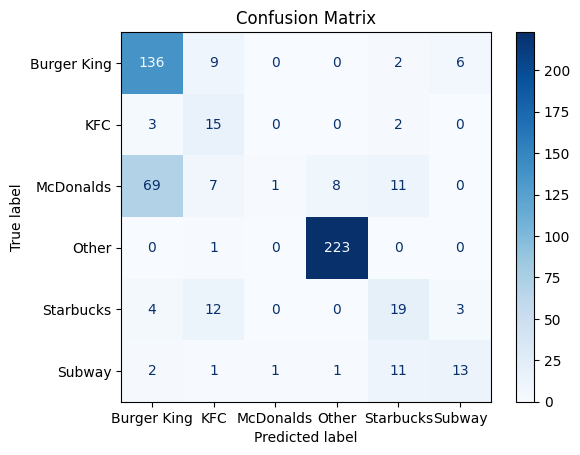

Classification Report:
              precision    recall  f1-score   support

 Burger King       0.64      0.89      0.74       153
         KFC       0.33      0.75      0.46        20
   McDonalds       0.50      0.01      0.02        96
       Other       0.96      1.00      0.98       224
   Starbucks       0.42      0.50      0.46        38
      Subway       0.59      0.45      0.51        29

    accuracy                           0.73       560
   macro avg       0.57      0.60      0.53       560
weighted avg       0.71      0.73      0.67       560



In [35]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
plt.figure(figsize=(8,6))
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Comparison of the earlier and finetuned Model performance metrics

In [36]:
metrics_df = pd.DataFrame({
    "Model": ["Frozen", "Fine-Tuned"],
    "Accuracy": [frozen_acc, finetuned_acc],
    "Precision": [frozen_prec, finetuned_prec],
    "Recall": [frozen_rec, finetuned_rec],
    "F1-Score": [frozen_f1, finetuned_f1]
})
metrics_df

,Model,Accuracy,Precision,Recall,F1-Score
0,Frozen,62.678571,0.573902,0.626786,0.593001
1,Fine-Tuned,72.678571,0.714985,0.726786,0.671169
